In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.io as pio
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely.geometry import Point#helps to create a point used to identify an area of a map
import geodatasets
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import r2_score
pio.renderers.default = "notebook"  #makes it render on jupyter notebook(displayy)


In [2]:
#!pip install geopandas
#!pip install matplotlib
#!pip install geodatasets
#!pip install seaborn
#!pip install xgboost
#!pip install scikit-learn

## EXPLORATORY DATA ANALYSIS

In [3]:
#getting the latitude and longitued of cities in kenya from jinyi-solar.com
nasa_wind_dataset_kenya = pd.read_excel("/home/raduma/csa2025/Renewable-Energy-Potential-Analyzer/data/nasa_dataset_50M_10M.xlsx")
kenya_coordinate_data = pd.read_excel("/home/raduma/csa2025/Renewable-Energy-Potential-Analyzer/data/kenya_coordinate_data.xlsx")
nasa_wind_dataset_kenya

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0     Nairobi  2018      1              21.44                5.33   
1     Nairobi  2018      2              21.61                7.41   
2     Nairobi  2018      3              19.27                4.73   
3     Nairobi  2018      4              18.72                4.97   
4     Nairobi  2018      5              17.83                4.59   
...       ...   ...    ...                ...                 ...   
5455    Tsavo  2024      9              25.04                6.76   
5456    Tsavo  2024     10              26.54                5.73   
5457    Tsavo  2024     11              26.46                4.05   
5458    Tsavo  2024     12              25.76                3.76   
5459    Tsavo  2024     13              25.33                5.31   

      Surface_Pressure_kPa  
0                    83.57  
1                    83.57  
2                    83.61  
3                    83.63  
4                    83.75  
...                    ...  
5455                 96.64  
5456                 96.50  
5457                 96.35  
5458                 96.39  
5459                 96.50  

[5460 rows x 6 columns]

In [4]:
nasa_wind_dataset_kenya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Town                  5460 non-null   object 
 1   Year                  5460 non-null   int64  
 2   Month                 5460 non-null   int64  
 3   Avg_Temperature_C     5460 non-null   float64
 4   Avg_Wind_Speed_m/s    5460 non-null   float64
 5   Surface_Pressure_kPa  5460 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 256.1+ KB


In [5]:
#!pip install plotly

In [6]:
#deleting all the columns where month ==13
df_refined= nasa_wind_dataset_kenya.drop(
    nasa_wind_dataset_kenya[nasa_wind_dataset_kenya['Month'] == 13].index
)
df_refined

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0     Nairobi  2018      1              21.44                5.33   
1     Nairobi  2018      2              21.61                7.41   
2     Nairobi  2018      3              19.27                4.73   
3     Nairobi  2018      4              18.72                4.97   
4     Nairobi  2018      5              17.83                4.59   
...       ...   ...    ...                ...                 ...   
5454    Tsavo  2024      8              23.93                7.16   
5455    Tsavo  2024      9              25.04                6.76   
5456    Tsavo  2024     10              26.54                5.73   
5457    Tsavo  2024     11              26.46                4.05   
5458    Tsavo  2024     12              25.76                3.76   

      Surface_Pressure_kPa  
0                    83.57  
1                    83.57  
2                    83.61  
3                    83.63  
4                    83.75  
...                    ...  
5454                 96.72  
5455                 96.64  
5456                 96.50  
5457                 96.35  
5458                 96.39  

[5040 rows x 6 columns]

In [7]:
#creating Air Density from the available data
R = 287.05
df_refined["Air_Density"] = (df_refined["Surface_Pressure_kPa"]* 1000)/((df_refined["Avg_Temperature_C"]+273.15) * R)
df_refined

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0     Nairobi  2018      1              21.44                5.33   
1     Nairobi  2018      2              21.61                7.41   
2     Nairobi  2018      3              19.27                4.73   
3     Nairobi  2018      4              18.72                4.97   
4     Nairobi  2018      5              17.83                4.59   
...       ...   ...    ...                ...                 ...   
5454    Tsavo  2024      8              23.93                7.16   
5455    Tsavo  2024      9              25.04                6.76   
5456    Tsavo  2024     10              26.54                5.73   
5457    Tsavo  2024     11              26.46                4.05   
5458    Tsavo  2024     12              25.76                3.76   

      Surface_Pressure_kPa  Air_Density  
0                    83.57     0.988268  
1                    83.57     0.987698  
2                    83.61     0.996079  
3                    83.63     0.998194  
4                    83.75     1.002684  
...                    ...          ...  
5454                 96.72     1.134189  
5455                 96.64     1.129032  
5456                 96.50     1.121754  
5457                 96.35     1.120309  
5458                 96.39     1.123399  

[5040 rows x 7 columns]

In [8]:
#creating column for wind power density using the formulae 
df_refined["Wind_Power_Density"] = 0.5 *(df_refined["Air_Density"]) * (df_refined["Avg_Wind_Speed_m/s"]**3)
df_refined

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0     Nairobi  2018      1              21.44                5.33   
1     Nairobi  2018      2              21.61                7.41   
2     Nairobi  2018      3              19.27                4.73   
3     Nairobi  2018      4              18.72                4.97   
4     Nairobi  2018      5              17.83                4.59   
...       ...   ...    ...                ...                 ...   
5454    Tsavo  2024      8              23.93                7.16   
5455    Tsavo  2024      9              25.04                6.76   
5456    Tsavo  2024     10              26.54                5.73   
5457    Tsavo  2024     11              26.46                4.05   
5458    Tsavo  2024     12              25.76                3.76   

      Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0                    83.57     0.988268           74.821512  
1                    83.57     0.987698          200.931919  
2                    83.61     0.996079           52.704418  
3                    83.63     0.998194           61.270900  
4                    83.75     1.002684           48.481069  
...                    ...          ...                 ...  
5454                 96.72     1.134189          208.158616  
5455                 96.64     1.129032          174.387916  
5456                 96.50     1.121754          105.519173  
5457                 96.35     1.120309           37.211137  
5458                 96.39     1.123399           29.858468  

[5040 rows x 8 columns]

In [9]:
df_refined["Wind_Power_Density"].max()

np.float64(759.7124384805455)

In [10]:
#creating an excel filed called Wind_Power_Monthly
df_refined.to_excel('Wind_Power_Monthly.xlsx', index=False)

In [11]:
# Grouping by Year and Town
grouped_yearly_means = df_refined.groupby(['Town', 'Year'])[
    ['Avg_Temperature_C', 'Avg_Wind_Speed_m/s', 'Surface_Pressure_kPa', 'Air_Density', 'Wind_Power_Density']
].mean().reset_index()
grouped_yearly_means

Town  Year  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0    Bungoma  2018          21.725833            3.456667   
1    Bungoma  2019          22.235833            3.511667   
2    Bungoma  2020          21.561667            3.413333   
3    Bungoma  2021          22.116667            3.565833   
4    Bungoma  2022          22.383333            3.500833   
..       ...   ...                ...                 ...   
415     Wote  2020          21.270000            4.462500   
416     Wote  2021          21.370000            4.674167   
417     Wote  2022          21.295833            4.710833   
418     Wote  2023          21.385000            4.685000   
419     Wote  2024          21.908333            4.318333   

     Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0               86.920833     1.026918           25.430061  
1               86.916667     1.025100           26.201422  
2               86.934167     1.027639           23.155314  
3               86.893333     1.025224           26.947414  
4               86.871667     1.024056           24.543102  
..                    ...          ...                 ...  
415             87.844167     1.039426           47.248446  
416             87.842500     1.039069           54.491419  
417             87.828333     1.039169           54.841443  
418             87.879167     1.039448           54.104293  
419             87.880833     1.037611           43.705970  

[420 rows x 7 columns]

In [12]:
seven_year_means = df_refined.groupby('Town')[
    ['Avg_Temperature_C', 'Avg_Wind_Speed_m/s', 'Surface_Pressure_kPa', 'Air_Density', 'Wind_Power_Density']
].mean().reset_index()
seven_year_means

Town  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0         Bungoma          22.165238            3.467619   
1           Busia          22.165238            3.467619   
2   Eldama Ravine          15.670119            3.578571   
3         Eldoret          19.065595            3.930119   
4            Embu          20.199286            4.393452   
5         Garissa          27.448452            7.155119   
6            Hola          27.681786            6.468929   
7        Homa Bay          23.608571            3.553214   
8          Isiolo          22.765476            5.650952   
9            Iten          19.250119            2.729048   
10       Kabarnet          19.250119            2.729048   
11        Kajiado          20.257024            5.565833   
12       Kakamega          19.065595            3.930119   
13     Kapenguria          17.259524            4.158571   
14       Kapsabet          20.521429            3.334405   
15        Karungu          22.113810            3.939643   
16       Kathwana          24.717500            4.816429   
17      Kendu Bay          23.608571            3.553214   
18        Kericho          20.031667            3.602738   
19       Kerugoya          20.199286            4.393452   
20         Kiambu          18.613095            5.207738   
21         Kilifi          26.788095            6.383452   
22          Kisii          20.031667            3.602738   
23         Kisumu          20.521429            3.334405   
24         Kitale          17.259524            4.158571   
25          Kitui          23.628929            4.254286   
26          Konza          19.863690            5.657262   
27          Kwale          25.769762            6.182381   
28           Lamu          27.106310            7.223690   
29         Lodwar          29.453690            5.731548   
30       Machakos          20.889881            4.601786   
31        Malindi          26.643929            6.636190   
32        Maralal          20.606429            5.294524   
33       Marsabit          26.555714            8.079286   
34           Meru          17.212143            5.190595   
35         Migori          22.113810            3.939643   
36        Mombasa          26.964643            6.831310   
37         Moyale          25.092500            6.861905   
38       Murang’a          16.014048            4.655714   
39        Mwatate          21.715000            5.374524   
40         Mwingi          23.629881            4.502500   
41        Nairobi          19.863690            5.657262   
42       Naivasha          15.235595            4.228095   
43         Nakuru          15.235595            4.228095   
44        Namanga          21.647619            4.245595   
45        Nanyuki          17.776667            4.670595   
46          Narok          17.917024            5.120952   
47        Nyamira          20.031667            3.602738   
48          Nyeri          16.014048            4.655714   
49       Ol Kalou          15.235595            4.228095   
50       Rumuruti          21.747262            4.628571   
51          Siaya          23.064524            3.356905   
52          Sotik          20.031667            3.602738   
53     Sotik Post          17.917024            5.120952   
54          Thika          18.613095            5.207738   
55          Tsavo          25.155714            5.325000   
56            Voi          23.741310            5.365833   
57          Wajir          27.695000            7.072619   
58           Witu          27.106310            7.223690   
59           Wote          21.439524            4.578929   

    Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0              86.917262     1.025346           24.916028  
1              86.917262     1.025346           24.916028  
2              77.524643     0.935099           24.986379  
3              82.026071     0.977903           46.993351  
4              85.881548     1.019920           44.2

In [13]:
#merging seven years means to the kenya coordinate data
town_coords = kenya_coordinate_data[['City', 'latitude', 'longitude']]
town_coords.columns = ['Town', 'Latitude', 'Longitude']

map_data = pd.merge(seven_year_means, town_coords, on='Town', how='left')
map_data

Town  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0         Bungoma          22.165238            3.467619   
1           Busia          22.165238            3.467619   
2   Eldama Ravine          15.670119            3.578571   
3         Eldoret          19.065595            3.930119   
4            Embu          20.199286            4.393452   
5         Garissa          27.448452            7.155119   
6            Hola          27.681786            6.468929   
7        Homa Bay          23.608571            3.553214   
8          Isiolo          22.765476            5.650952   
9            Iten          19.250119            2.729048   
10       Kabarnet          19.250119            2.729048   
11        Kajiado          20.257024            5.565833   
12       Kakamega          19.065595            3.930119   
13     Kapenguria          17.259524            4.158571   
14       Kapsabet          20.521429            3.334405   
15        Karungu          22.113810            3.939643   
16       Kathwana          24.717500            4.816429   
17      Kendu Bay          23.608571            3.553214   
18        Kericho          20.031667            3.602738   
19       Kerugoya          20.199286            4.393452   
20         Kiambu          18.613095            5.207738   
21         Kilifi          26.788095            6.383452   
22          Kisii          20.031667            3.602738   
23         Kisumu          20.521429            3.334405   
24         Kitale          17.259524            4.158571   
25          Kitui          23.628929            4.254286   
26          Konza          19.863690            5.657262   
27          Kwale          25.769762            6.182381   
28           Lamu          27.106310            7.223690   
29         Lodwar          29.453690            5.731548   
30       Machakos          20.889881            4.601786   
31        Malindi          26.643929            6.636190   
32        Maralal          20.606429            5.294524   
33       Marsabit          26.555714            8.079286   
34           Meru          17.212143            5.190595   
35         Migori          22.113810            3.939643   
36        Mombasa          26.964643            6.831310   
37         Moyale          25.092500            6.861905   
38       Murang’a          16.014048            4.655714   
39        Mwatate          21.715000            5.374524   
40         Mwingi          23.629881            4.502500   
41        Nairobi          19.863690            5.657262   
42       Naivasha          15.235595            4.228095   
43         Nakuru          15.235595            4.228095   
44        Namanga          21.647619            4.245595   
45        Nanyuki          17.776667            4.670595   
46          Narok          17.917024            5.120952   
47        Nyamira          20.031667            3.602738   
48          Nyeri          16.014048            4.655714   
49       Ol Kalou          15.235595            4.228095   
50       Rumuruti          21.747262            4.628571   
51          Siaya          23.064524            3.356905   
52          Sotik          20.031667            3.602738   
53     Sotik Post          17.917024            5.120952   
54          Thika          18.613095            5.207738   
55          Tsavo          25.155714            5.325000   
56            Voi          23.741310            5.365833   
57          Wajir          27.695000            7.072619   
58           Witu          27.106310            7.223690   
59           Wote          21.439524            4.578929   

    Surface_Pressure_kPa  Air_Density  Wind_Power_Density  Latitude  Longitude  
0              86.917262     1.025346           24.916028    0.5704    34.5600  
1              86.917262     1.025346           24.916028    0.4586    34.1160  
2              77.524643     0.935099           24.986379    0.0504    35.7200  
3              82.026071    

## VISUALIZATION

In [14]:
#creating an interactive map showing the average wind power density over the last 7years
fig = px.scatter_map(
    map_data,
    lat="Latitude",
    lon="Longitude",
    color="Wind_Power_Density",
    size="Wind_Power_Density",
    hover_name="Town",
    color_continuous_scale=[(0, "blue"), (1, "red")],
    size_max=15,
    zoom=5,
    title="Average Wind Power Density by Town (2018–2024)",
    height=600
)
fig.update_layout(mapbox_style="carto-positron")

fig.show()

In [15]:
#getting the top 6 Wind Power Density Potential Region in Kenya
map_data_top_6 = map_data.nlargest(6, 'Wind_Power_Density').reset_index(drop=True)
map_data_top_6

Town  Avg_Temperature_C  Avg_Wind_Speed_m/s  Surface_Pressure_kPa  \
0  Marsabit          26.555714            8.079286             94.111667   
1   Garissa          27.448452            7.155119             98.216190   
2      Lamu          27.106310            7.223690            101.145000   
3      Witu          27.106310            7.223690            101.145000   
4   Mombasa          26.964643            6.831310            101.194881   
5     Wajir          27.695000            7.072619             97.481548   

   Air_Density  Wind_Power_Density  Latitude  Longitude  
0     1.093959          308.644513    2.3300    37.9800  
1     1.138294          267.155348   -0.4396    39.6700  
2     1.173559          259.638717   -2.2620    40.9197  
3     1.173559          259.638717   -2.3796    40.4300  
4     1.174690          229.883074   -4.0400    39.6899  
5     1.128859          219.358825    1.7504    40.0500

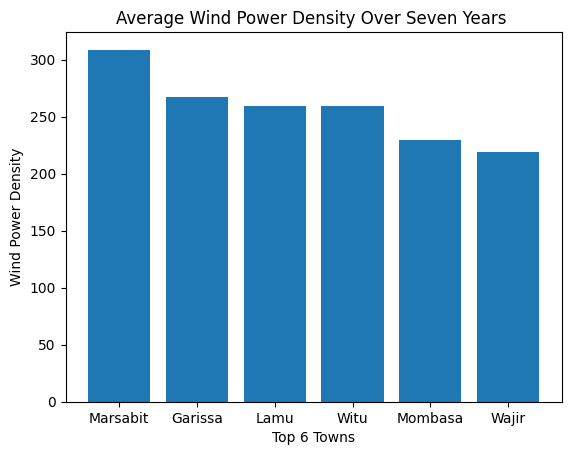

In [16]:
categories = map_data_top_6["Town"]
values = map_data_top_6["Wind_Power_Density"]
plt.xlabel("Top 6 Towns")
plt.ylabel("Wind Power Density")
plt.title("Average Wind Power Density Over Seven Years ")
plt.bar(categories, values);

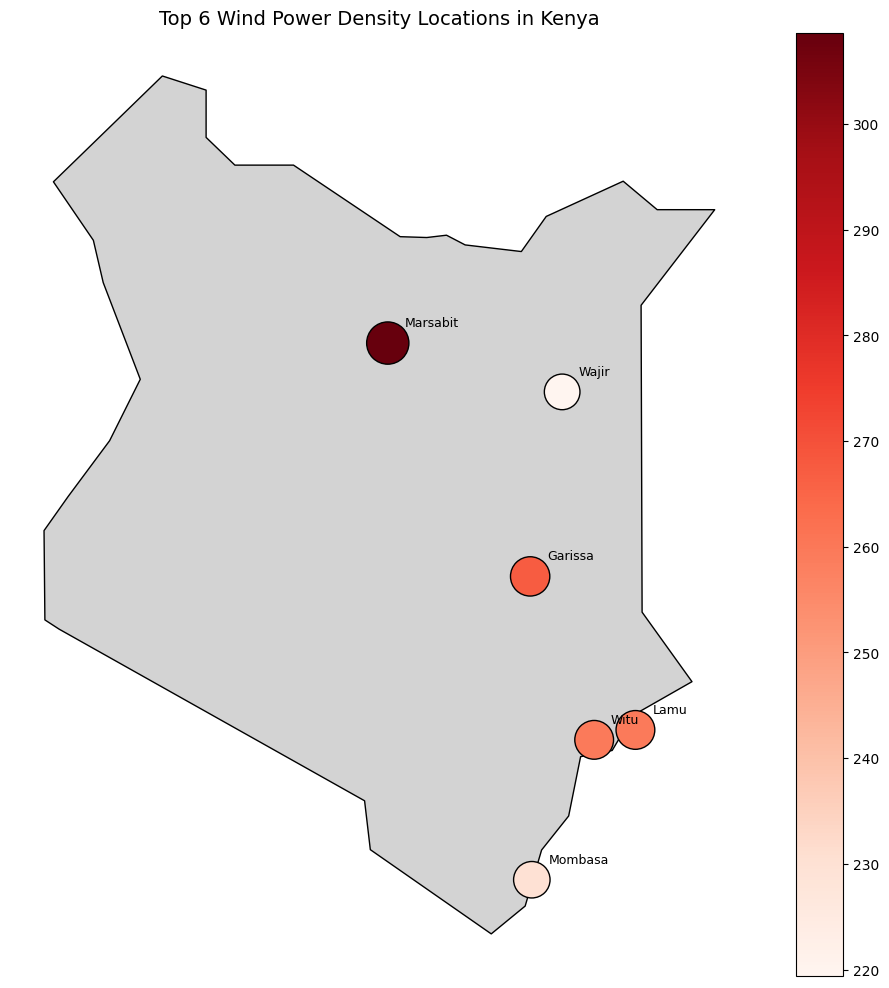

In [17]:
#plotting a static graph of the top 6 
#Convert the top 5 DataFrame into a GeoDataFrame
geometry = [Point(xy) for xy in zip(map_data_top_6["Longitude"], map_data_top_6["Latitude"])]#value to use as the active geometry column.
geo_top6 = gpd.GeoDataFrame(map_data_top_6, geometry=geometry, crs="EPSG:4326")#crating a column called geometry and assigning to geometry variable

#Load country boundaries from Natural Earth via URL
world = gpd.read_file("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson")
kenya = world[world["NAME"] == "Kenya"]

# Step 3: Plot
fig, ax = plt.subplots(figsize=(10, 10))
kenya.plot(ax=ax, color='lightgray', edgecolor='black')
geo_top6.plot(
    ax=ax,
    column='Wind_Power_Density',
    cmap='Reds',
    legend=True,
    markersize=geo_top6['Wind_Power_Density'] * 3,
    edgecolor='black'
)

# Annotate towns
for x, y, label in zip(geo_top6["Longitude"], geo_top6["Latitude"], geo_top6["Town"]):
    ax.text(x + 0.2, y + 0.2, label, fontsize=9)#putting the town name slightly away from the point so it doesn’t overlap the marker.

plt.title("Top 6 Wind Power Density Locations in Kenya", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()





In [18]:
#top6_towns_data_per_month.to_excel("geo_top6.xlsx",index =False)


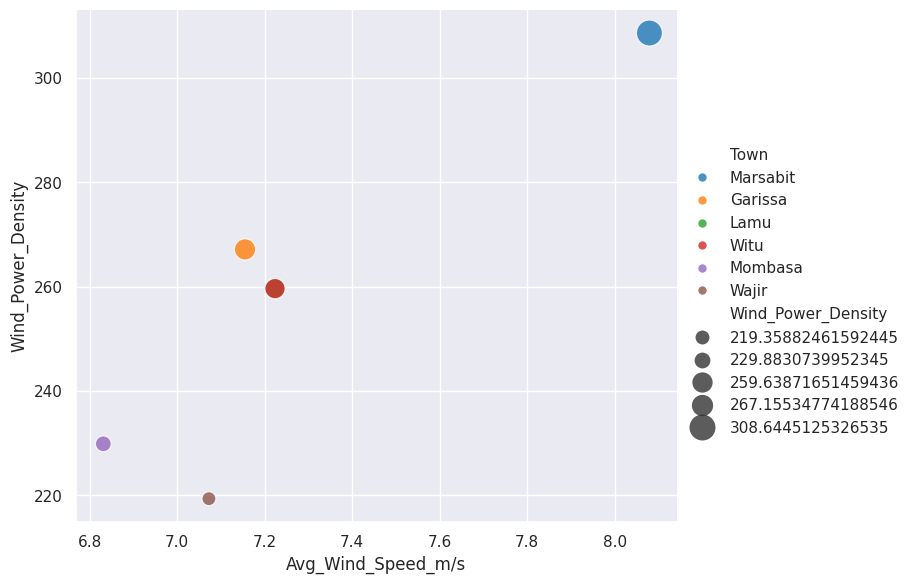

In [19]:
#checking the relationship of wind denstiy and wind speed in the top 5 potential counties
sns.set_theme()

sns.relplot(
    data = map_data_top_6,
    x = "Avg_Wind_Speed_m/s",
    y =  "Wind_Power_Density",
    hue = "Town",
    sizes=(100,350),
    size="Wind_Power_Density",
    alpha=0.8,                     
    palette="tab10",              
    height=6,
    aspect=1.2
);
#do remember this is 

In [20]:
# fig, ax = plt.subplots(figsize=(10, 10))
# kenya.plot(ax=ax, color='lightgray', edgecolor='black')

# # Assign a colormap to categories
# category_colors = {
#     'Very_Low': '#f7fcfd',
#     'Low': '#FF0000',
#     'Low_Medium': '#a8ddb5',
#     'Medium': '#43a2ca',
#     'Feasible': '#0868ac'
# }

# # Plot each category separately for legend control
# for category, color in category_colors.items():
#     subset = geo_top6[geo_top6["Density_Category"] == category]
#     if subset.empty:
#         continue
        
#     subset.plot(
#         ax=ax,
#         color=color,
#         markersize=subset["Wind_Power_Density"],
#         edgecolor="black",
#         label=category
#     )

# # Add labels (custom tooltips on hover is not possible in static plots)
# for x, y, label in zip(geo_top6["Longitude"], geo_top6["Latitude"], geo_top6["Town"]):
#     ax.text(x + 0.1, y + 0.1, label, fontsize=9)

# plt.title("Top 6 Wind Power Density Locations in Kenya (Binned)", fontsize=14)
# plt.legend(title="Wind Density Category")
# plt.axis("off")
# plt.tight_layout()
# plt.show()


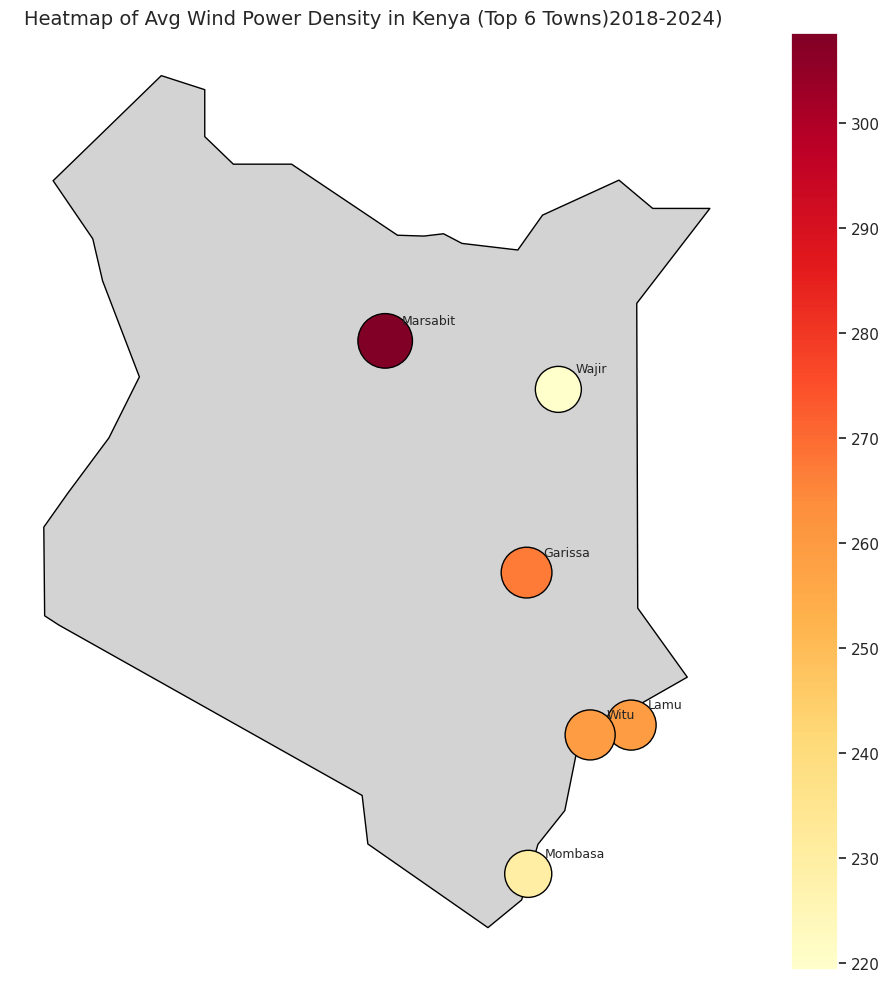

In [21]:

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base Kenya shapefile
kenya.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot geo_top6 as a heatmap (based on Wind_Power_Density)
geo_top6.plot(
    ax=ax,
    column='Wind_Power_Density',  # This enables gradient coloring
    cmap='YlOrRd',                # Choose a continuous colormap
    markersize=geo_top6["Wind_Power_Density"] * 5,  # Adjust size as needed
    legend=True,
    edgecolor='black'
)

# Add labels for towns
for x, y, label in zip(geo_top6["Longitude"], geo_top6["Latitude"], geo_top6["Town"]):
    ax.text(x + 0.2, y + 0.2, label, fontsize=9)

plt.title("Heatmap of Avg Wind Power Density in Kenya (Top 6 Towns)2018-2024) ", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [22]:
#Getting the top 6 towns over the years
selected_towns = ['Marsabit', 'Garissa', 'Wajir', "Witu", "Lamu", "Mombasa"]
top6_towns_data_per_year = grouped_yearly_means[grouped_yearly_means['Town'].isin(selected_towns)].reset_index(drop=True)
top6_towns_data_per_year

Town  Year  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0    Garissa  2018          27.235833            7.203333   
1    Garissa  2019          27.757500            6.994167   
2    Garissa  2020          27.255000            7.147500   
3    Garissa  2021          27.428333            7.369167   
4    Garissa  2022          27.207500            7.287500   
5    Garissa  2023          27.215000            6.889167   
6    Garissa  2024          28.040000            7.195000   
7       Lamu  2018          26.739167            7.245000   
8       Lamu  2019          27.279167            7.106667   
9       Lamu  2020          27.151667            7.252500   
10      Lamu  2021          26.904167            7.404167   
11      Lamu  2022          26.851667            7.394167   
12      Lamu  2023          27.090000            6.845000   
13      Lamu  2024          27.728333            7.318333   
14  Marsabit  2018          26.103333            8.114167   
15  Marsabit  2019          27.062500            8.085000   
16  Marsabit  2020          26.500833            7.766667   
17  Marsabit  2021          26.385000            8.330833   
18  Marsabit  2022          26.279167            8.394167   
19  Marsabit  2023          26.370000            8.096667   
20  Marsabit  2024          27.189167            7.767500   
21   Mombasa  2018          26.668333            6.796667   
22   Mombasa  2019          27.210833            6.748333   
23   Mombasa  2020          27.044167            6.938333   
24   Mombasa  2021          26.676667            7.014167   
25   Mombasa  2022          26.570833            6.899167   
26   Mombasa  2023          27.041667            6.492500   
27   Mombasa  2024          27.540000            6.930000   
28     Wajir  2018          27.215000            7.070000   
29     Wajir  2019          27.997500            7.010833   
30     Wajir  2020          27.790000            6.980833   
31     Wajir  2021          27.898333            7.325833   
32     Wajir  2022          27.115000            7.183333   
33     Wajir  2023          27.278333            6.817500   
34     Wajir  2024          28.570833            7.120000   
35      Witu  2018          26.739167            7.245000   
36      Witu  2019          27.279167            7.106667   
37      Witu  2020          27.151667            7.252500   
38      Witu  2021          26.904167            7.404167   
39      Witu  2022          26.851667            7.394167   
40      Witu  2023          27.090000            6.845000   
41      Witu  2024          27.728333            7.318333   

    Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0              98.226667     1.139226          266.967212  
1              98.200833     1.136954          246.357550  
2              98.201667     1.138845          276.588049  
3              98.216667     1.138375          291.753426  
4              98.204167     1.139080          281.218534  
5              98.243333     1.139490          239.561572  
6              98.220000     1.136091          267.641090  
7             101.160000     1.175168          253.932361  
8             101.127500     1.172678          246.948084  
9             101.120000     1.173092          271.802029  
10            101.160000     1.174520          276.904373  
11            101.141667     1.174524          275.510213  
12            101.161667     1.173806          223.498762  
13            101.144167     1.171123          268.875194  
14             94.121667     1.095729          320.885889  
15             94.099167     1.091975          305.906949  
16             94.102500     1.094041          272.159465  
17             94.104167     1.094491          335.344370  
18             94.088333     1.094700          343.890492  
19             94.140000     1.094969          309.774432  
20             94.125833     1.091809          272.549991  
21            101.209167     1.176011          219.849996  
22  

## Data that will be used for time series for the top 6 towns

In [23]:
#
selected_6_towns = ['Marsabit', 'Garissa', 'Wajir', "Witu", "Lamu", "Mombasa"]
top6_towns_data_per_month = df_refined[df_refined['Town'].isin(selected_6_towns)].reset_index(drop=True)
top6_towns_data_per_month.to_excel("6_High_Potential_Towns.xlsx")

In [24]:
#extractind data for Marsabit(Highest Potential)
marsabit_data = top6_towns_data_per_month[top6_towns_data_per_month["Town"] == "Marsabit"].reset_index(drop=True)
marsabit_data

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0   Marsabit  2018      1              27.56                6.67   
1   Marsabit  2018      2              28.48                8.40   
2   Marsabit  2018      3              26.59                6.07   
3   Marsabit  2018      4              24.75                5.73   
4   Marsabit  2018      5              25.12                8.05   
..       ...   ...    ...                ...                 ...   
79  Marsabit  2024      8              25.86                9.15   
80  Marsabit  2024      9              27.08                9.71   
81  Marsabit  2024     10              28.52                8.73   
82  Marsabit  2024     11              26.83                6.63   
83  Marsabit  2024     12              27.35                6.91   

    Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0                  93.96     1.088523          161.504673  
1                  93.94     1.084972          321.533578  
2                  93.97     1.092162          122.130195  
3                  94.03     1.099609          103.436127  
4                  94.13     1.099413          286.760005  
..                   ...          ...                 ...  
79                 94.27     1.098323          420.691299  
80                 94.18     1.092816          500.235769  
81                 94.07     1.086329          361.388397  
82                 94.04     1.092101          159.137803  
83                 94.09     1.090791          179.947405  

[84 rows x 8 columns]

In [25]:
#extractind data for Marsabit(Highest Potential)
garissa_data = top6_towns_data_per_month[top6_towns_data_per_month["Town"] == "Garissa"].reset_index(drop=True)
garissa_data

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0   Garissa  2018      1              29.03                4.90   
1   Garissa  2018      2              29.91                5.59   
2   Garissa  2018      3              28.16                4.63   
3   Garissa  2018      4              26.75                6.20   
4   Garissa  2018      5              26.08                8.30   
..      ...   ...    ...                ...                 ...   
79  Garissa  2024      8              26.32                9.82   
80  Garissa  2024      9              27.41                9.68   
81  Garissa  2024     10              28.79                8.29   
82  Garissa  2024     11              28.13                5.06   
83  Garissa  2024     12              29.19                4.76   

    Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0                  97.99     1.129688           66.453328  
1                  98.01     1.126638           98.398765  
2                  98.01     1.133181           56.235721  
3                  98.08     1.139322          135.766153  
4                  98.23     1.143619          326.953312  
..                   ...          ...                 ...  
79                 98.42     1.144913          542.096938  
80                 98.34     1.139834          516.936915  
81                 98.20     1.133009          322.750469  
82                 98.09     1.134219           73.471420  
83                 98.13     1.130703           60.973272  

[84 rows x 8 columns]

In [26]:
#extractind data for Marsabit(Highest Potential)
lamu_data = top6_towns_data_per_month[top6_towns_data_per_month["Town"] == "Lamu"].reset_index(drop=True)
lamu_data

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0   Lamu  2018      1              26.95                6.70   
1   Lamu  2018      2              27.53                6.26   
2   Lamu  2018      3              28.08                4.96   
3   Lamu  2018      4              27.70                6.51   
4   Lamu  2018      5              26.98                8.30   
..   ...   ...    ...                ...                 ...   
79  Lamu  2024      8              25.97                9.17   
80  Lamu  2024      9              26.26                8.21   
81  Lamu  2024     10              27.18                7.02   
82  Lamu  2024     11              28.40                4.82   
83  Lamu  2024     12              28.46                5.87   

    Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0                 100.90     1.171299          176.141639  
1                 100.95     1.169619          143.462117  
2                 100.89     1.166789           71.188097  
3                 100.96     1.169073          161.270430  
4                 101.13     1.173851          335.596428  
..                   ...          ...                 ...  
79                101.41     1.181076          455.360957  
80                101.34     1.179117          326.254509  
81                101.18     1.173649          203.011083  
82                100.99     1.166706           65.323975  
83                101.03     1.166936          118.013414  

[84 rows x 8 columns]

In [27]:
witu_data = top6_towns_data_per_month[top6_towns_data_per_month["Town"] == "Witu"].reset_index(drop=True)
witu_data

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0   Witu  2018      1              26.95                6.70   
1   Witu  2018      2              27.53                6.26   
2   Witu  2018      3              28.08                4.96   
3   Witu  2018      4              27.70                6.51   
4   Witu  2018      5              26.98                8.30   
..   ...   ...    ...                ...                 ...   
79  Witu  2024      8              25.97                9.17   
80  Witu  2024      9              26.26                8.21   
81  Witu  2024     10              27.18                7.02   
82  Witu  2024     11              28.40                4.82   
83  Witu  2024     12              28.46                5.87   

    Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0                 100.90     1.171299          176.141639  
1                 100.95     1.169619          143.462117  
2                 100.89     1.166789           71.188097  
3                 100.96     1.169073          161.270430  
4                 101.13     1.173851          335.596428  
..                   ...          ...                 ...  
79                101.41     1.181076          455.360957  
80                101.34     1.179117          326.254509  
81                101.18     1.173649          203.011083  
82                100.99     1.166706           65.323975  
83                101.03     1.166936          118.013414  

[84 rows x 8 columns]

In [28]:
mombasa_data = top6_towns_data_per_month[top6_towns_data_per_month["Town"] == "Mombasa"].reset_index(drop=True)
mombasa_data

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0   Mombasa  2018      1              26.55                6.40   
1   Mombasa  2018      2              27.20                5.53   
2   Mombasa  2018      3              27.81                4.44   
3   Mombasa  2018      4              27.79                6.41   
4   Mombasa  2018      5              27.44                8.44   
..      ...   ...    ...                ...                 ...   
79  Mombasa  2024      8              25.80                8.40   
80  Mombasa  2024      9              25.81                7.30   
81  Mombasa  2024     10              26.67                6.03   
82  Mombasa  2024     11              28.02                4.28   
83  Mombasa  2024     12              28.07                5.25   

    Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0                 100.93     1.173211          153.775060  
1                 100.98     1.171252           99.036567  
2                 100.92     1.168183           51.124589  
3                 101.01     1.169303          153.982369  
4                 101.19     1.172750          352.535503  
..                   ...          ...                 ...  
79                101.49     1.182680          350.489495  
80                101.41     1.181708          229.852235  
81                101.24     1.176343          128.960268  
82                101.02     1.168525           45.807798  
83                101.05     1.168678           84.555698  

[84 rows x 8 columns]

In [29]:
wajir_data = top6_towns_data_per_month[top6_towns_data_per_month["Town"] == "Wajir"].reset_index(drop=True)
wajir_data

Town  Year  Month  Avg_Temperature_C  Avg_Wind_Speed_m/s  \
0   Wajir  2018      1              28.75                6.77   
1   Wajir  2018      2              30.09                7.00   
2   Wajir  2018      3              28.06                5.28   
3   Wajir  2018      4              26.15                4.80   
4   Wajir  2018      5              25.45                6.68   
..    ...   ...    ...                ...                 ...   
79  Wajir  2024      8              27.05                9.05   
80  Wajir  2024      9              28.25                8.59   
81  Wajir  2024     10              29.73                7.60   
82  Wajir  2024     11              28.44                5.49   
83  Wajir  2024     12              28.69                6.25   

    Surface_Pressure_kPa  Air_Density  Wind_Power_Density  
0                  97.28     1.122543          174.156187  
1                  97.28     1.117582          191.665368  
2                  97.29     1.125230           82.815769  
3                  97.38     1.133458           62.675704  
4                  97.52     1.137749          169.568715  
..                   ...          ...                 ...  
79                 97.67     1.133425          420.057449  
80                 97.58     1.127873          357.445234  
81                 97.44     1.120751          245.991391  
82                 97.37     1.124736           93.054573  
83                 97.43     1.124497          137.267719  

[84 rows x 8 columns]

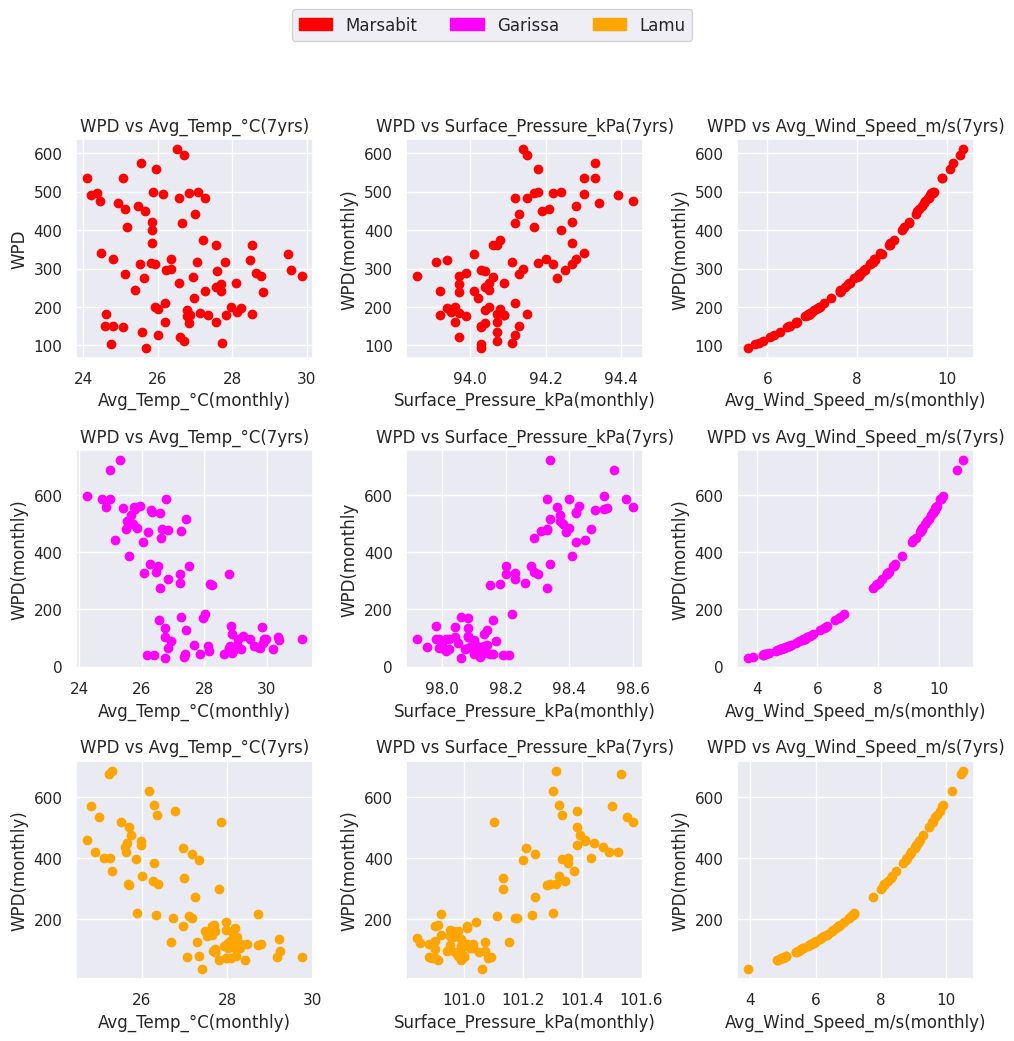

In [30]:
#subplots for the top 3 Towns per month for the last 7 years
fig, axis = plt.subplots(3,3, figsize=(10,10))

legend_elements = [
    Patch(facecolor='red', edgecolor='red', label='Marsabit'),
    Patch(facecolor='magenta', edgecolor='magenta', label='Garissa'),
    Patch(facecolor='orange', edgecolor='orange', label='Lamu')
]


#scatter plots for Marsabit
x=marsabit_data["Avg_Temperature_C"]
y=marsabit_data["Wind_Power_Density"]
axis[0, 0].scatter(x, y, color='red')
axis[0, 0].set_title("WPD vs Avg_Temp_°C(7yrs)")
axis[0, 0].set_xlabel('Avg_Temp_°C(monthly)')
axis[0, 0].set_ylabel('WPD')

x=marsabit_data["Avg_Wind_Speed_m/s"]
y=marsabit_data["Wind_Power_Density"]
axis[0, 2].scatter(x, y, color='red')
axis[0, 2].set_title("WPD vs Avg_Wind_Speed_m/s(7yrs)")
axis[0, 2].set_xlabel('Avg_Wind_Speed_m/s(monthly)')
axis[0, 2].set_ylabel('WPD(monthly)')

x=marsabit_data["Surface_Pressure_kPa"]
y=marsabit_data["Wind_Power_Density"]
axis[0, 1].scatter(x, y, color='red')
axis[0, 1].set_title("WPD vs Surface_Pressure_kPa(7yrs)")
axis[0, 1].set_xlabel('Surface_Pressure_kPa(monthly)')
axis[0, 1].set_ylabel('WPD(monthly)')


#scatter plots data for Garissa
x=garissa_data["Avg_Temperature_C"]
y=garissa_data["Wind_Power_Density"]
axis[1, 0].scatter(x, y, color='magenta')
axis[1, 0].set_title("WPD vs Avg_Temp_°C(7yrs)")
axis[1, 0].set_xlabel('Avg_Temp_°C(monthly)')
axis[1, 0].set_ylabel('WPD(monthly)')

x=garissa_data["Avg_Wind_Speed_m/s"]
y=garissa_data["Wind_Power_Density"]
axis[1, 2].scatter(x, y, color='magenta')
axis[1, 2].set_title("WPD vs Avg_Wind_Speed_m/s(7yrs)")
axis[1, 2].set_xlabel('Avg_Wind_Speed_m/s(monthly)')
axis[1, 2].set_ylabel('WPD(monthly)')

x=garissa_data["Surface_Pressure_kPa"]
y=garissa_data["Wind_Power_Density"]
axis[1, 1].scatter(x, y, color='magenta')
axis[1, 1].set_title("WPD vs Surface_Pressure_kPa(7yrs)")
axis[1, 1].set_xlabel('Surface_Pressure_kPa(monthly)')
axis[1, 1].set_ylabel('WPD(monthly')


#scatter plots data for Lamu
x=lamu_data["Avg_Temperature_C"]
y=lamu_data["Wind_Power_Density"]
axis[2, 0].scatter(x, y, color='orange')
axis[2, 0].set_title("WPD vs Avg_Temp_°C(7yrs)")
axis[2, 0].set_xlabel('Avg_Temp_°C(monthly)')
axis[2, 0].set_ylabel('WPD(monthly)')

x=lamu_data["Avg_Wind_Speed_m/s"]
y=lamu_data["Wind_Power_Density"]
axis[2, 2].scatter(x, y, color='orange')
axis[2, 2].set_title("WPD vs Avg_Wind_Speed_m/s(7yrs)")
axis[2, 2].set_xlabel('Avg_Wind_Speed_m/s(monthly)')
axis[2, 2].set_ylabel('WPD(monthly)')

x=lamu_data["Surface_Pressure_kPa"]
y=lamu_data["Wind_Power_Density"]
axis[2, 1].scatter(x, y, color='orange')
axis[2, 1].set_title("WPD vs Surface_Pressure_kPa(7yrs)")
axis[2, 1].set_xlabel('Surface_Pressure_kPa(monthly)')
axis[2, 1].set_ylabel('WPD(monthly)')

fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize='medium',bbox_to_anchor=(0.5, 1.0) )
plt.tight_layout(rect=[0, 0, 1, 0.95])#reserving the top are to be similar to 
plt.show()

In [31]:
# #using the bike data real temperature to know whether 
# #create a density plot to visualize distribution of real temperature
# ax = bike_data['real_temperature'].plot.density (title='Distribution of real temperature',label='real_temperature')#this is from the pandas library

# #get the column mean
# mean_real_temp = bike_data['real_temperature'].mean()

# #plot the column mean
# plt.axvline(x=mean_real_temp, color = 'r', linestyle ='dotted', label='mean')
# ax.legend();

In [32]:
# #CREATE A FIGURE OBJECT FOR THE DISTRIBUTION PLOT
# fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,8))

# ax1 = bike_data['real_temperature'].plot.density (ax =ax1,title='Distribution of real temperature',label='real_temperature')#this is from the pandas library
# #we are initialsiznax as ax1, ax from line 31
# #get the column mean
# mean_real_temp = bike_data['real_temperature'].mean()

# #plot the column mean
# ax1.axvline(x=mean_real_temp, color = 'r', linestyle ='dotted', label='mean')
# ax1.legend(loc = 'lower right');



# ax2 = bike_data['scaled_real_temp'].plot.density (ax =ax2,title='Distribution of scaled_real_temp',label='scaled_real_temperature')#this is from the pandas library

# #get the column mean
# mean_scaled_real_temp = bike_data['scaled_real_temp'].mean()

# #plot the column mean
# ax2.axvline(x=mean_scaled_real_temp, color = 'r', linestyle ='dotted', label='scaled_mean')
# ax2.legend(loc = 'lower right')

### correlation for the top 3

In [33]:
map_data_top_6

Town  Avg_Temperature_C  Avg_Wind_Speed_m/s  Surface_Pressure_kPa  \
0  Marsabit          26.555714            8.079286             94.111667   
1   Garissa          27.448452            7.155119             98.216190   
2      Lamu          27.106310            7.223690            101.145000   
3      Witu          27.106310            7.223690            101.145000   
4   Mombasa          26.964643            6.831310            101.194881   
5     Wajir          27.695000            7.072619             97.481548   

   Air_Density  Wind_Power_Density  Latitude  Longitude  
0     1.093959          308.644513    2.3300    37.9800  
1     1.138294          267.155348   -0.4396    39.6700  
2     1.173559          259.638717   -2.2620    40.9197  
3     1.173559          259.638717   -2.3796    40.4300  
4     1.174690          229.883074   -4.0400    39.6899  
5     1.128859          219.358825    1.7504    40.0500

In [34]:
#filtering out the numerical variable of the top 6 Towns
marsabit_num_variables = marsabit_data.select_dtypes(include='number').drop(columns=["Year", "Month", "Air_Density"])
garissa_num_variables = garissa_data.select_dtypes(include='number').drop(columns=["Year", "Month", "Air_Density"])
lamu_num_variables = lamu_data.select_dtypes(include='number').drop(columns=["Year", "Month", "Air_Density"])
witu_num_variables = witu_data.select_dtypes(include='number').drop(columns=["Year", "Month", "Air_Density"])
mombasa_num_variables = mombasa_data.select_dtypes(include='number').drop(columns=["Year", "Month", "Air_Density"])
wajir_num_variables =wajir_data.select_dtypes(include='number').drop(columns=["Year", "Month", "Air_Density"])
wajir_num_variables

Avg_Temperature_C  Avg_Wind_Speed_m/s  Surface_Pressure_kPa  \
0               28.75                6.77                 97.28   
1               30.09                7.00                 97.28   
2               28.06                5.28                 97.29   
3               26.15                4.80                 97.38   
4               25.45                6.68                 97.52   
..                ...                 ...                   ...   
79              27.05                9.05                 97.67   
80              28.25                8.59                 97.58   
81              29.73                7.60                 97.44   
82              28.44                5.49                 97.37   
83              28.69                6.25                 97.43   

    Wind_Power_Density  
0           174.156187  
1           191.665368  
2            82.815769  
3            62.675704  
4           169.568715  
..                 ...  
79          420.057449  
80          357.445234  
81          245.991391  
82           93.054573  
83          137.267719  

[84 rows x 4 columns]

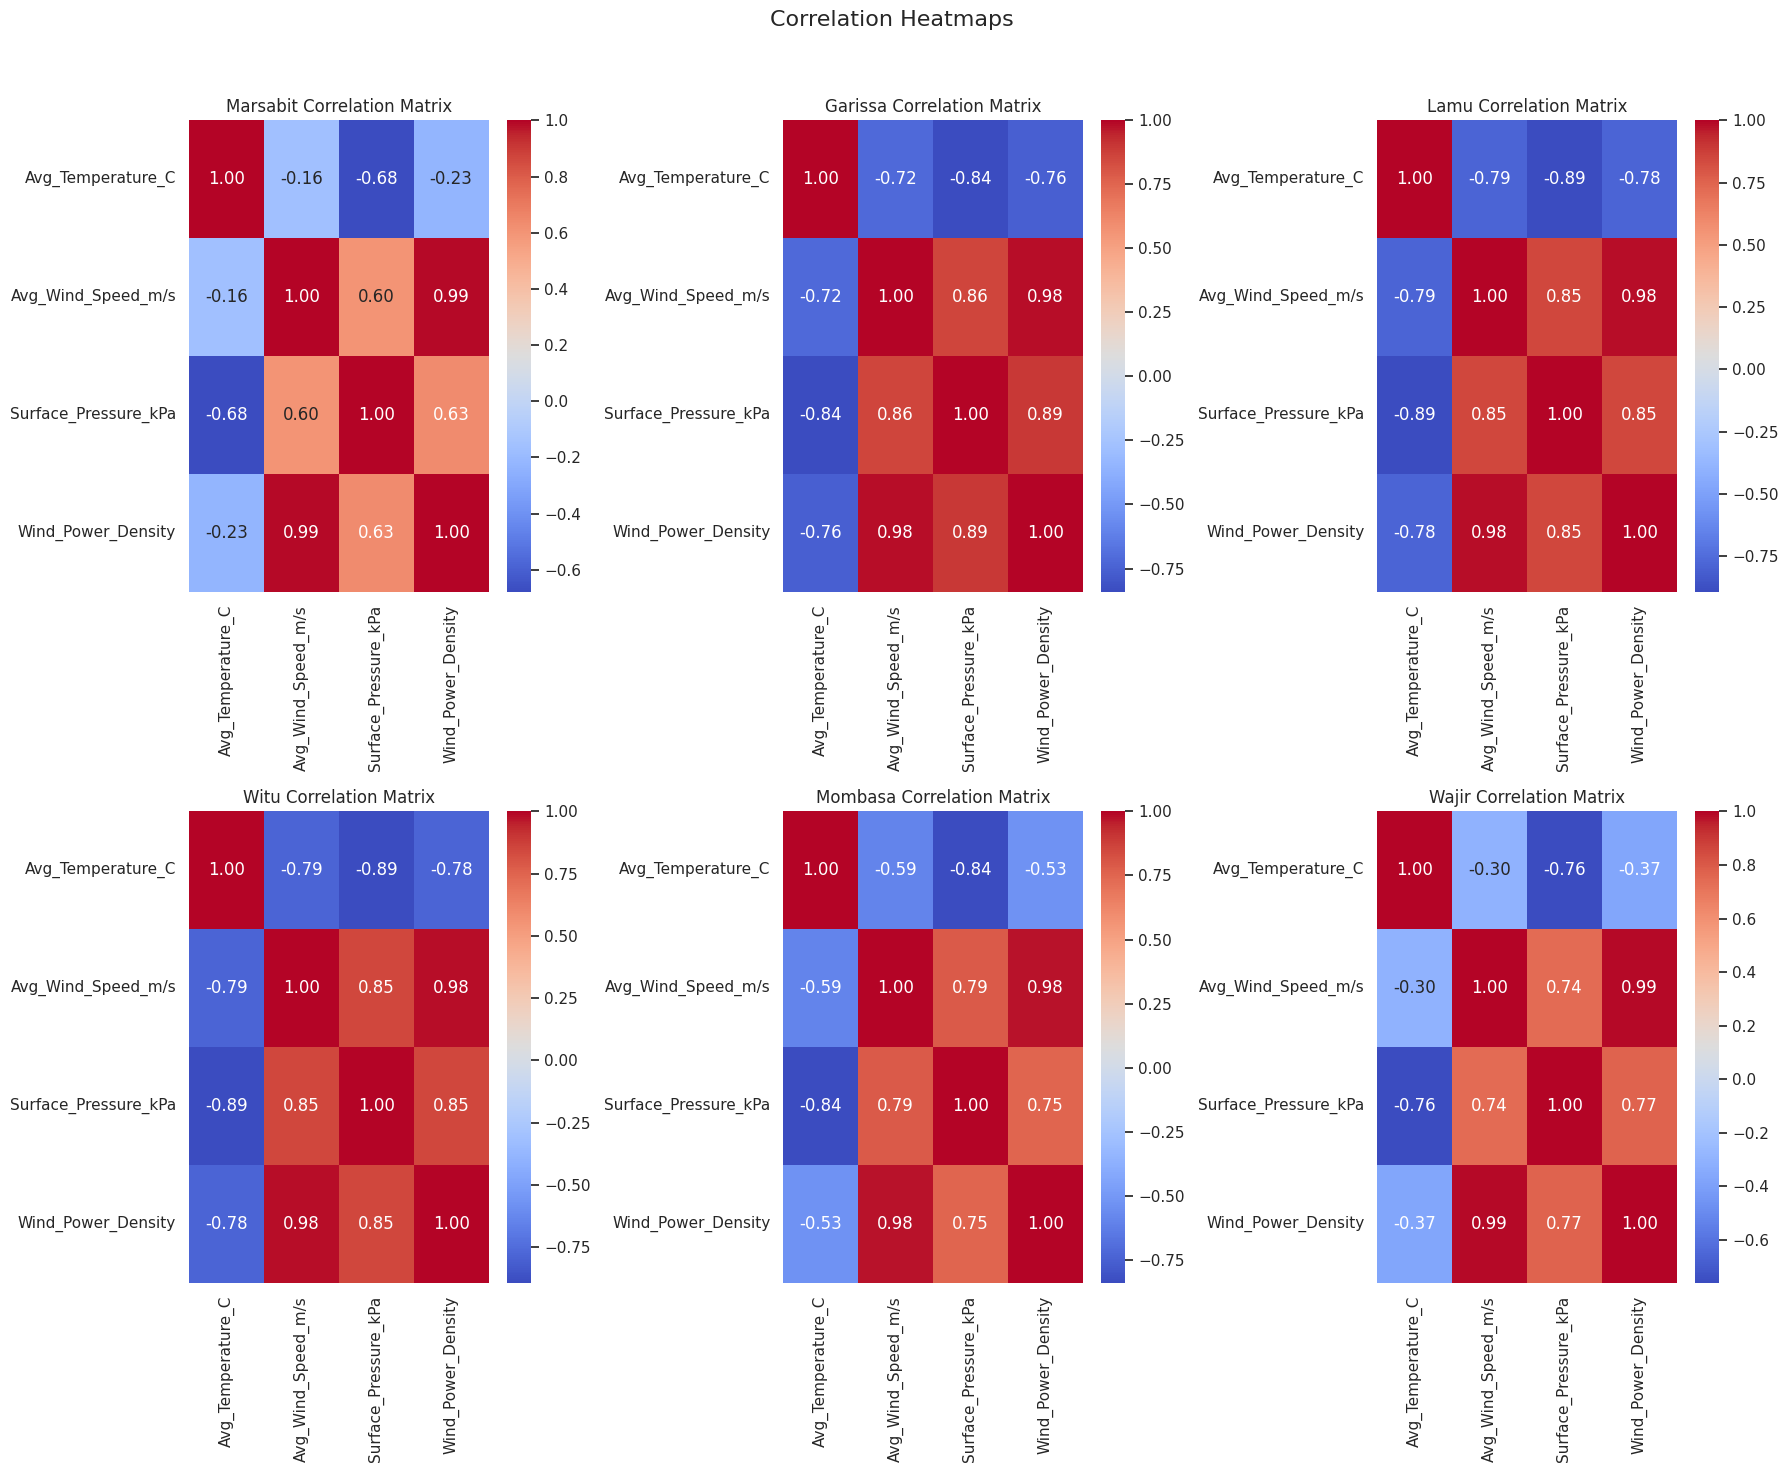

In [35]:
#create a correlation matrix
fig, axis = plt.subplots(2, 3, figsize=(18, 14))

# Correlation Heatmap for Marsabit
marsabit_corr_matrix = marsabit_num_variables.corr()
sns.heatmap(marsabit_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", ax=axis[0, 0])
axis[0, 0].set_title("Marsabit Correlation Matrix")

# Correlation Heatmap for Garissa 
garissa_corr_matrix = garissa_num_variables.corr()
sns.heatmap(garissa_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", ax=axis[0, 1])
axis[0, 1].set_title("Garissa Correlation Matrix")

# Correlation Heatmap for Lamu
lamu_corr_matrix = lamu_num_variables.corr()
sns.heatmap(lamu_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", ax=axis[0, 2])
axis[0, 2].set_title("Lamu Correlation Matrix")

# Correlation Heatmap for Witu
witu_corr_matrix = witu_num_variables.corr()
sns.heatmap(witu_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", ax=axis[1, 0])
axis[1, 0].set_title("Witu Correlation Matrix")

# Correlation Heatmap for Witu
mombasa_corr_matrix = mombasa_num_variables.corr()
sns.heatmap(mombasa_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", ax=axis[1, 1])
axis[1, 1].set_title("Mombasa Correlation Matrix")

# Correlation Heatmap for Wajir
wajir_corr_matrix = wajir_num_variables.corr()
sns.heatmap(wajir_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", ax=axis[1, 2])
axis[1, 2].set_title("Wajir Correlation Matrix")


# Final layout tweaks
plt.tight_layout()
plt.suptitle("Correlation Heatmaps", fontsize=16, y=1.05)
plt.show()


In [36]:
#map_data

# test_data predictionof our model to see its accuracy before future

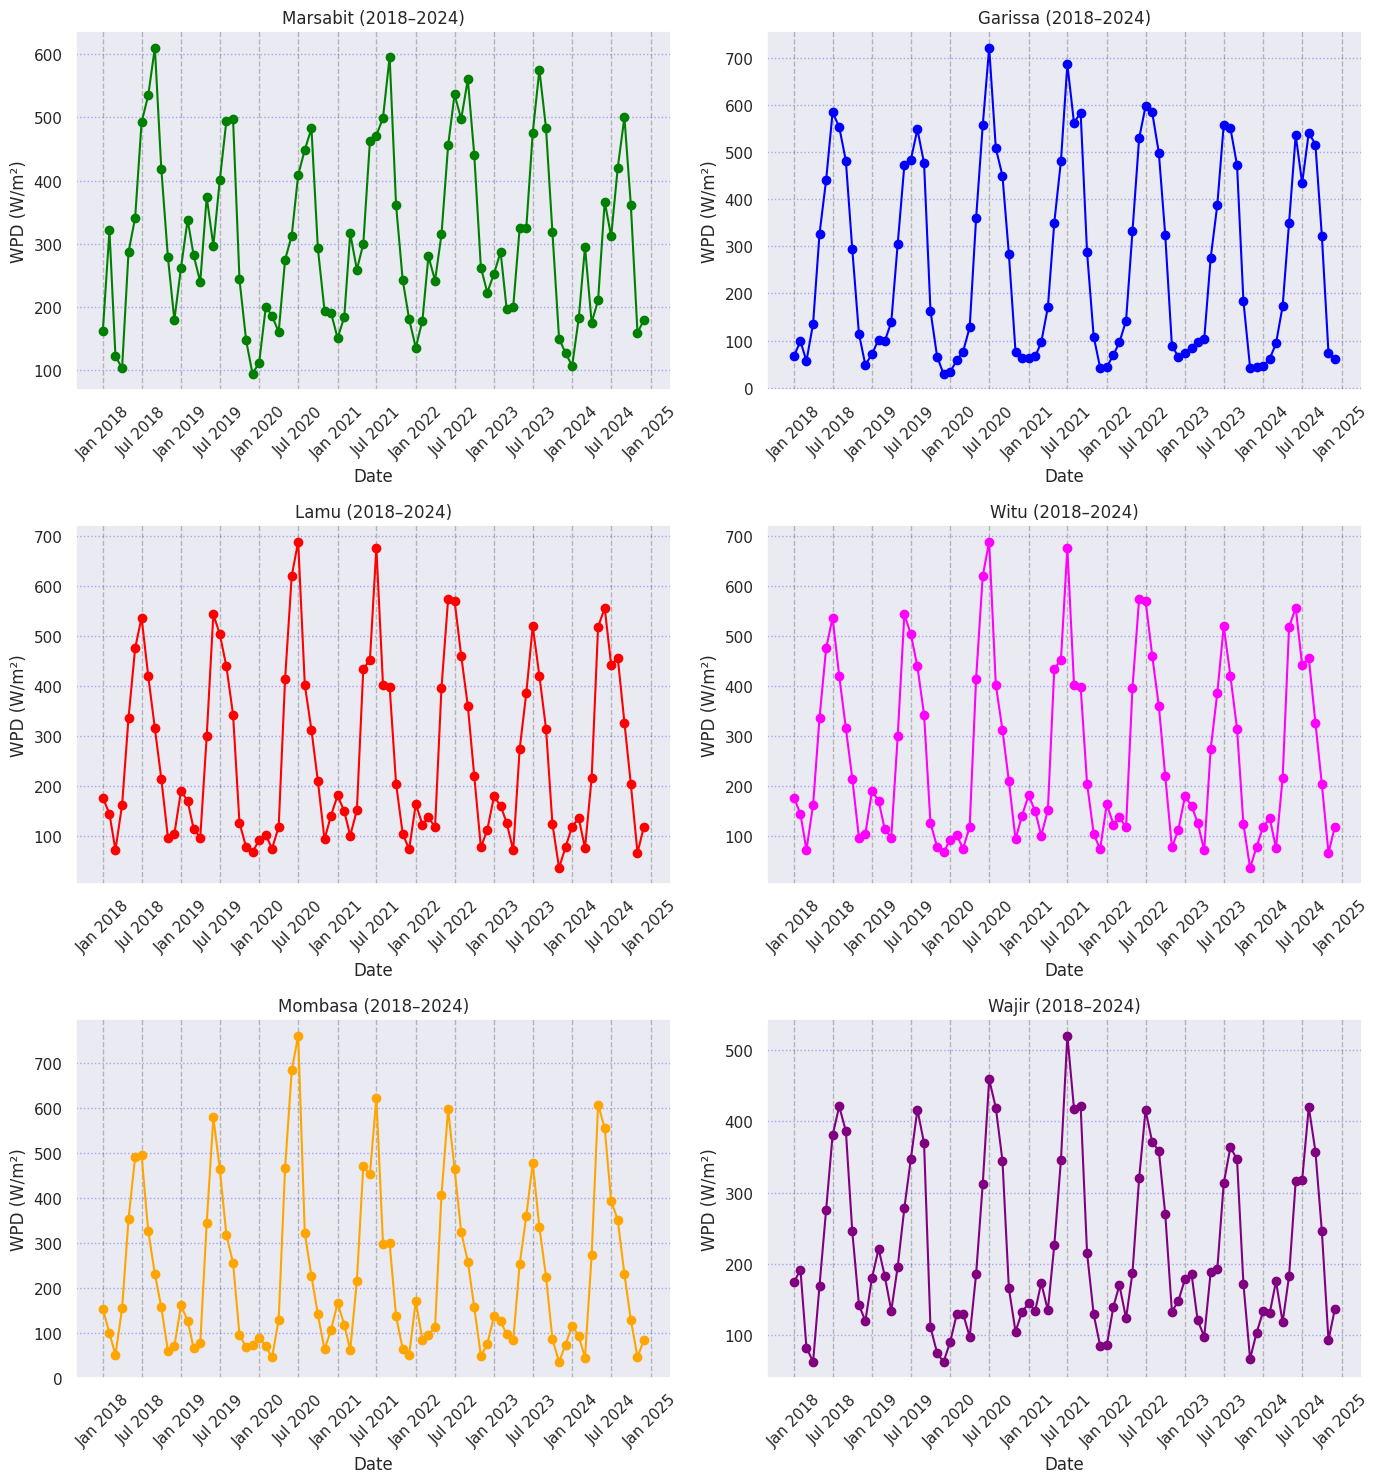

In [38]:

def monthly_wpd_subplots(town_datasets):
    """
    Plots Monthly Wind Power Density for multiple towns in a single figure with subplots.
    Each DataFrame must contain 'Year', 'Month', 'Wind_Power_Density', and 'Town'.
    """
    n = len(town_datasets)
    cols = 2
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), sharex=False)
    axes = axes.flatten() if n > 1 else [axes]

    # Define a color palette
    colors = ['green', 'blue', 'red', 'magenta', 'orange', 'purple', 'cyan', 'brown', 'darkgreen', 'black']

    for i, df in enumerate(town_datasets):
        if not {'Year', 'Month', 'Wind_Power_Density', 'Town'}.issubset(df.columns):
            print(f"Dataset {i} is missing required columns. Skipping...")
            continue

        df = df.copy()
        df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
        df = df.sort_values('Date')
        town_name = df['Town'].iloc[0]

        ax = axes[i]
        color = colors[i % len(colors)]  # Cycle through colors if more towns than colors
        ax.plot(df['Date'], df['Wind_Power_Density'], marker='o', color=color)

        ax.set_title(f"{town_name} (2018–2024)", fontsize=12)
        ax.set_xlabel('Date')
        ax.set_ylabel('WPD (W/m²)')

        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

        ax.grid(True, which='major', axis='x', linestyle='--', color='gray', alpha=0.5)
        ax.grid(True, which='major', axis='y', linestyle=':', color='blue', alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
town_datasets = [marsabit_data, garissa_data,lamu_data, witu_data, mombasa_data, wajir_data]
monthly_wpd_subplots(town_datasets)


Garissa - R² Score: 0.8926
Marsabit - R² Score: 0.5483
Lamu - R² Score: 0.7126
Witu - R² Score: 0.7126
Mombasa - R² Score: 0.5677
Wajir - R² Score: 0.6734


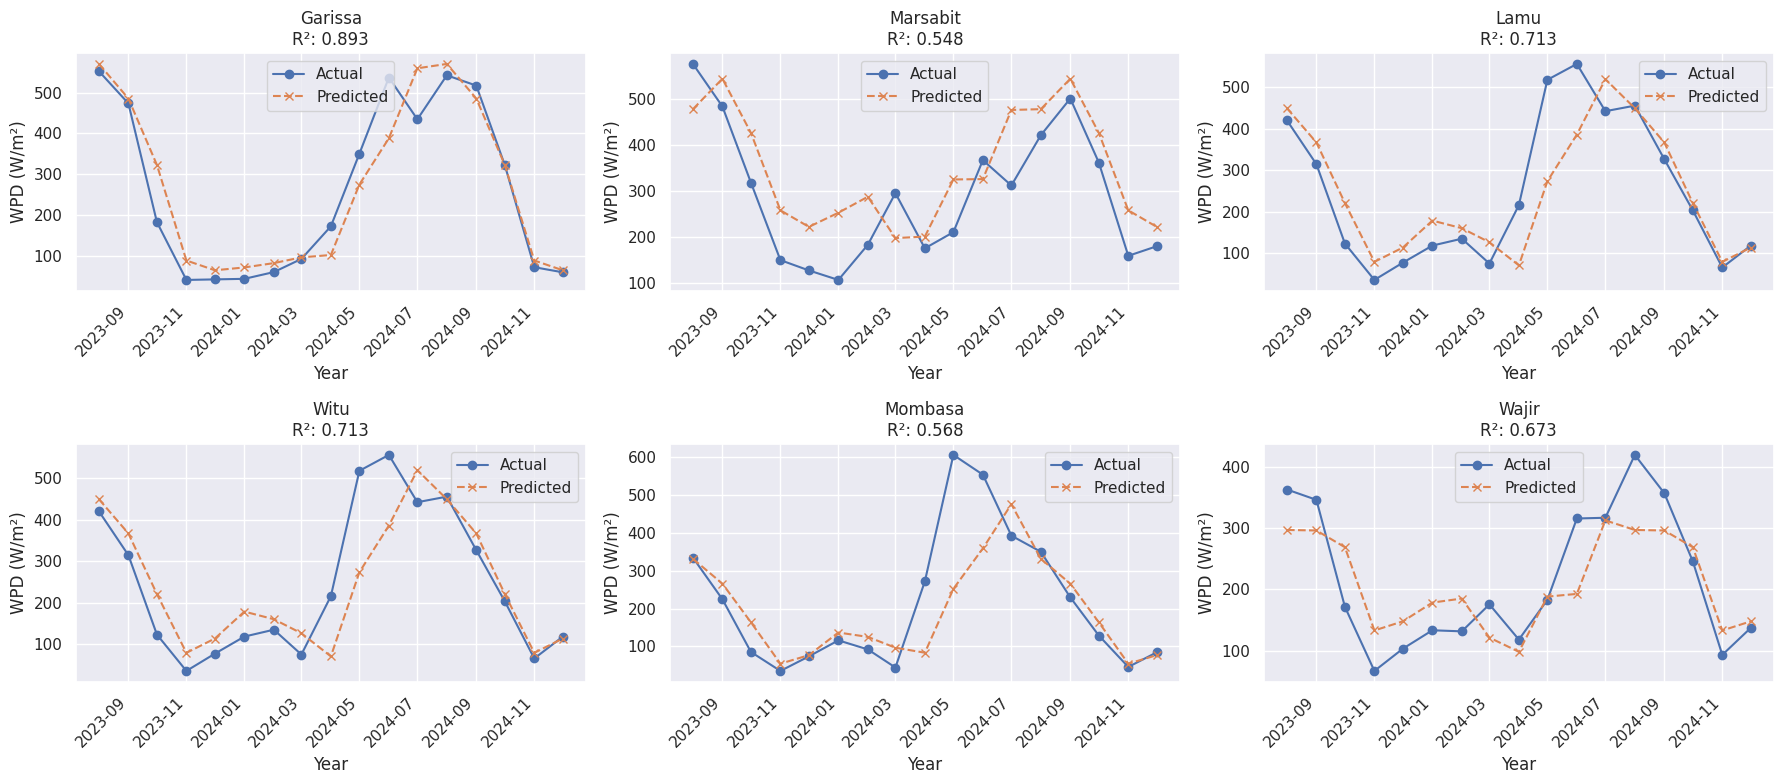

In [39]:
def train_evaluate_plot_models(town_datasets):
    """
    Trains XGBoost models, evaluates R², plots subplots of Actual vs Predicted WPD,
    and returns trained models and original data.
    """
    trained_models = {}
    dataframes = {}

    num_towns = len(town_datasets)
    ncols = 3
    nrows = -(-num_towns // ncols)  # Ceiling division

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows), sharex=False)
    axes = axes.flatten()

    for i, df in enumerate(town_datasets):
        if not {'Year', 'Month', 'Wind_Power_Density', 'Town'}.issubset(df.columns):
            print("Skipping town due to missing columns.")
            continue

        df = df.copy()
        df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
        df = df.sort_values('Date')

        X = df[['Year', 'Month']]
        y = df['Wind_Power_Density']
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        town_name = df['Town'].iloc[0]
        print(f"{town_name} - R² Score: {r2:.4f}")

        # Save the model and data
        trained_models[town_name] = model
        dataframes[town_name] = df

        # Plot actual vs predicted
        ax = axes[i]
        ax.plot(df['Date'].iloc[-len(y_test):], y_test.values, label='Actual', marker='o')
        ax.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted', linestyle='--', marker='x')
        ax.set_title(f"{town_name}\nR²: {r2:.3f}")
        ax.set_xlabel("Year")
        ax.set_ylabel("WPD (W/m²)")
        ax.legend()
        ax.grid(True)
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return trained_models, dataframes
town_datasets = [garissa_data, marsabit_data, lamu_data, witu_data, mombasa_data, wajir_data]

models, dataframes = train_evaluate_plot_models(town_datasets)


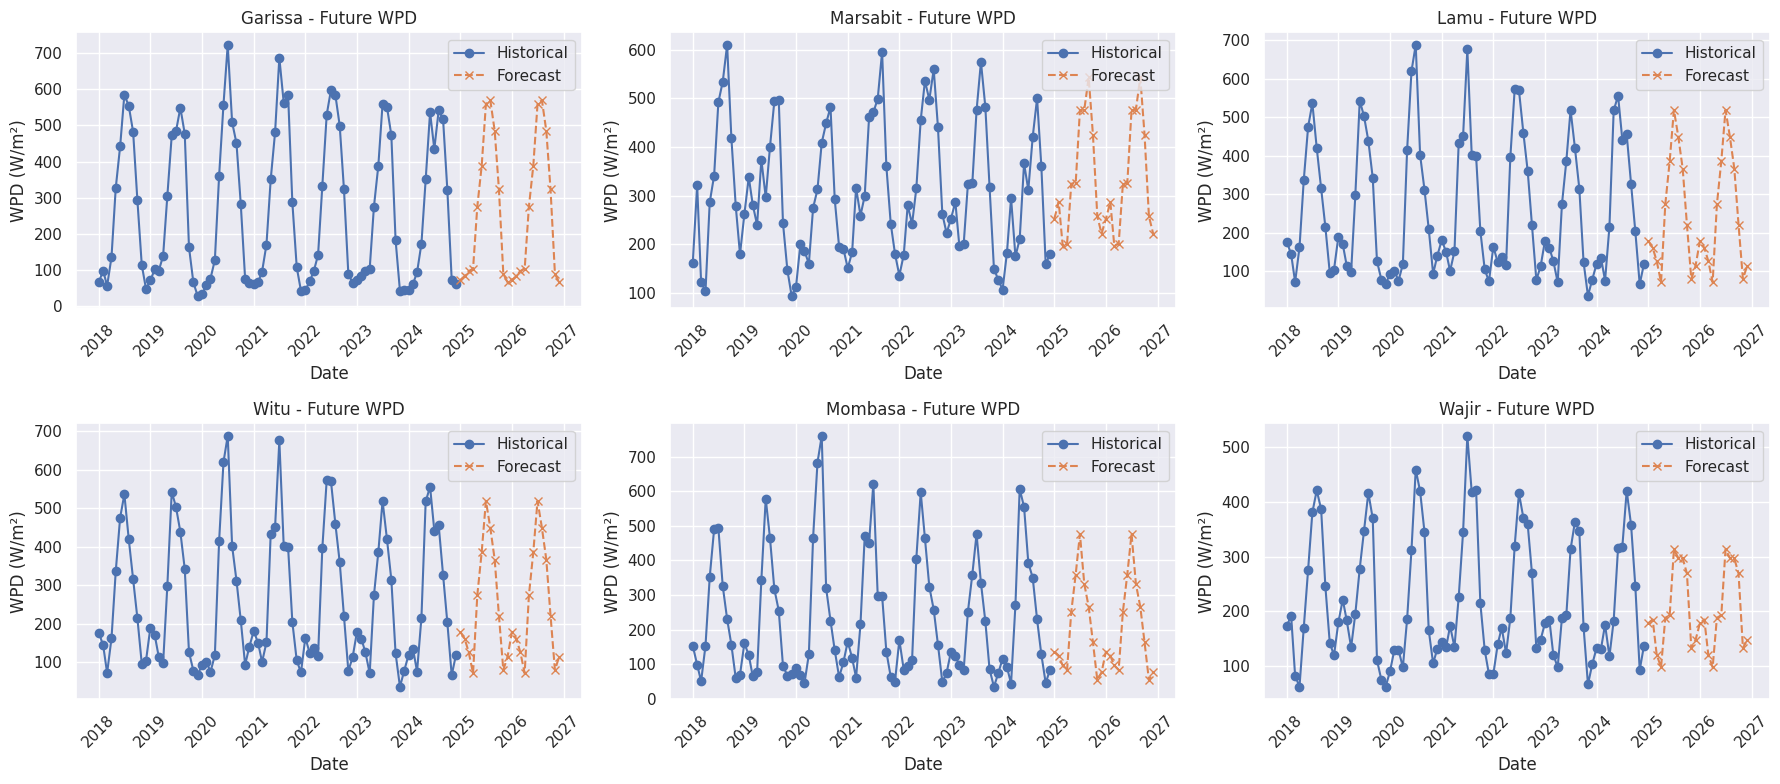

In [40]:
#calling that trained model to predict the future

def predict_future_wpd_subplots(trained_models, dataframes, months_to_predict=12):
    """
    Predicts future WPD values for each town using pretrained models and plots in subplots.
    """
    towns = list(trained_models.keys())
    cols = 3
    rows = (len(towns) + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(18, 4 * rows), sharex=False)
    axs = axs.flatten()

    for i, town in enumerate(towns):
        model = trained_models[town]
        df = dataframes[town]
        last_date = df['Date'].max()

        future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=months_to_predict, freq='MS')
        future_df = pd.DataFrame({
            'Year': future_dates.year,
            'Month': future_dates.month
        })

        future_pred = model.predict(future_df)

        ax = axs[i]
        ax.plot(df['Date'], df['Wind_Power_Density'], label='Historical', marker='o')
        ax.plot(future_dates, future_pred, label='Forecast', linestyle='--', marker='x')
        ax.set_title(f"{town} - Future WPD")
        ax.set_xlabel("Date")
        ax.set_ylabel("WPD (W/m²)")
        ax.legend()
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# Predict future WPD
predict_future_wpd_subplots(models, dataframes, months_to_predict=24)